# Distance Metrics and Recommendation Quality Assessment

This notebook evaluates different distance metrics for the fashion image recommender system and assesses recommendation quality using multiple evaluation metrics.

**Distance Metrics Compared:**
1. Euclidean Distance
2. Manhattan Distance
3. Cosine Similarity
4. Chebyshev Distance
5. Minkowski Distance (p=3)

**Recommendation Quality Metrics:**
1. Precision@K (K=1, 3, 5, 10)
2. Category Consistency
3. Subcategory Match Rate
4. Mean Reciprocal Rank (MRR)

## Import Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
from PIL import Image
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity
from scipy.spatial.distance import chebyshev, minkowski

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Data Preprocessing


### Extract Required Columns and Sample Data

In [18]:
data = "C:\\Users\\Admin\\DATA\\fashion-dataset\\data.csv"
df = pd.read_csv(data)

top_16 = df['subCategory'].value_counts().nlargest(16).index
filtered = df[df['subCategory'].isin(top_16)]
df_sample = filtered.groupby('subCategory', group_keys=False).sample(n=477, random_state=42)

print(f"Total samples: {len(df_sample)}")
print(f"Subcategories: {df_sample['subCategory'].nunique()}")

Total samples: 7632
Subcategories: 16


## Feature Extraction: PSVD on RGB Images

Using the original methodology with 90% variance threshold as the baseline for comparison.

### Load and Preprocess Images

In [19]:
image_dir = "C:\\Users\\Admin\\DATA\\fashion-dataset\\images"
target_size = (80, 60)
n_clusters = 16
random_state = 42

image_data_rgb = []
valid_ids = []

for idx in df_sample['id'].values:
    img_path = os.path.join(image_dir, f"{idx}.jpg")
    if not os.path.exists(img_path):
        continue
    
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float64) / 255.0
    
    image_data_rgb.append(img_array.flatten())
    valid_ids.append(idx)

image_data_rgb = np.array(image_data_rgb)
df_valid = df_sample[df_sample['id'].isin(valid_ids)].reset_index(drop=True)

print(f"RGB image matrix shape: {image_data_rgb.shape}")

RGB image matrix shape: (7631, 14400)


### Apply PSVD and K-means Clustering

In [20]:
mean_rgb = np.mean(image_data_rgb, axis=0)
data_centered_rgb = image_data_rgb - mean_rgb

U_rgb, S_rgb, Vt_rgb = np.linalg.svd(data_centered_rgb, full_matrices=False)

variance_rgb = (S_rgb ** 2) / (data_centered_rgb.shape[0] - 1)
explained_variance_ratio_rgb = variance_rgb / np.sum(variance_rgb)
cumulative_variance_rgb = np.cumsum(explained_variance_ratio_rgb)

n_components = np.argmax(cumulative_variance_rgb >= 0.90) + 1

Vt_reduced = Vt_rgb[:n_components, :]
features = np.dot(data_centered_rgb, Vt_reduced.T)

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state, n_init=10, max_iter=300)
cluster_labels = kmeans.fit_predict(features)

print(f"PSVD components: {n_components}")
print(f"Feature shape: {features.shape}")

PSVD components: 144
Feature shape: (7631, 144)


## Distance Metric Functions

### Implement Distance Calculation Functions

In [21]:
def get_top_k_recommendations(query_idx, features, cluster_labels, distance_metric, k=5):
    query_vector = features[query_idx]
    query_cluster = cluster_labels[query_idx]
    
    cluster_indices = np.setdiff1d(np.where(cluster_labels == query_cluster)[0], [query_idx])
    
    if len(cluster_indices) == 0:
        return np.array([])
    
    if distance_metric == 'euclidean':
        distances = np.sqrt(np.sum((features[cluster_indices] - query_vector) ** 2, axis=1))
    elif distance_metric == 'manhattan':
        distances = np.sum(np.abs(features[cluster_indices] - query_vector), axis=1)
    elif distance_metric == 'cosine':
        similarities = cosine_similarity(query_vector.reshape(1, -1), features[cluster_indices])[0]
        distances = 1 - similarities
    elif distance_metric == 'chebyshev':
        distances = np.array([chebyshev(query_vector, features[i]) for i in cluster_indices])
    elif distance_metric == 'minkowski':
        distances = np.array([minkowski(query_vector, features[i], p=3) for i in cluster_indices])
    else:
        raise ValueError(f"Unknown distance metric: {distance_metric}")
    
    top_k_indices = cluster_indices[np.argsort(distances)[:k]]
    return top_k_indices

distance_metrics = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']

## Recommendation Quality Metrics

### Define Quality Assessment Functions

In [22]:
def calculate_precision_at_k(query_idx, recommendations, true_labels, k_values=[1, 3, 5, 10]):
    query_category = true_labels[query_idx]['masterCategory']
    query_subcategory = true_labels[query_idx]['subCategory']
    
    precisions = {}
    for k in k_values:
        if len(recommendations) == 0:
            precisions[f'P@{k}'] = 0.0
            continue
        
        top_k = recommendations[:min(k, len(recommendations))]
        matches = sum(1 for idx in top_k if true_labels[idx]['subCategory'] == query_subcategory)
        precisions[f'P@{k}'] = matches / len(top_k) if len(top_k) > 0 else 0.0
    
    return precisions

def calculate_category_consistency(query_idx, recommendations, true_labels):
    if len(recommendations) == 0:
        return 0.0
    
    query_category = true_labels[query_idx]['masterCategory']
    matches = sum(1 for idx in recommendations if true_labels[idx]['masterCategory'] == query_category)
    return matches / len(recommendations)

def calculate_subcategory_match_rate(query_idx, recommendations, true_labels):
    if len(recommendations) == 0:
        return 0.0
    
    query_subcategory = true_labels[query_idx]['subCategory']
    matches = sum(1 for idx in recommendations if true_labels[idx]['subCategory'] == query_subcategory)
    return matches / len(recommendations)

def calculate_mrr(query_idx, recommendations, true_labels):
    if len(recommendations) == 0:
        return 0.0
    
    query_subcategory = true_labels[query_idx]['subCategory']
    for rank, idx in enumerate(recommendations, start=1):
        if true_labels[idx]['subCategory'] == query_subcategory:
            return 1.0 / rank
    return 0.0

def calculate_diversity_score(recommendations, features):
    if len(recommendations) < 2:
        return 0.0
    
    rec_features = features[recommendations]
    distances = euclidean_distances(rec_features)
    avg_distance = np.mean(distances[np.triu_indices_from(distances, k=1)])
    return avg_distance

## Evaluate All Distance Metrics

### Generate Recommendations and Calculate Metrics

In [23]:
true_labels = [{'masterCategory': df_valid.iloc[i]['masterCategory'], 
                'subCategory': df_valid.iloc[i]['subCategory']} 
               for i in range(len(df_valid))]

np.random.seed(42)
test_indices = np.random.choice(len(features), size=min(500, len(features)), replace=False)

results = {metric: defaultdict(list) for metric in distance_metrics}

for metric in distance_metrics:
    start_time = time.time()
    
    for query_idx in test_indices:
        recommendations = get_top_k_recommendations(query_idx, features, cluster_labels, metric, k=10)
        
        if len(recommendations) > 0:
            precisions = calculate_precision_at_k(query_idx, recommendations, true_labels)
            for k, v in precisions.items():
                results[metric][k].append(v)
            
            results[metric]['category_consistency'].append(
                calculate_category_consistency(query_idx, recommendations, true_labels)
            )
            results[metric]['subcategory_match'].append(
                calculate_subcategory_match_rate(query_idx, recommendations, true_labels)
            )
            results[metric]['mrr'].append(
                calculate_mrr(query_idx, recommendations, true_labels)
            )
            results[metric]['diversity'].append(
                calculate_diversity_score(recommendations, features)
            )
    
    results[metric]['computation_time'] = time.time() - start_time
    print(f"{metric}: {results[metric]['computation_time']:.2f}s")

euclidean: 0.63s
manhattan: 0.63s
cosine: 1.07s
chebyshev: 6.09s
minkowski: 7.81s


### Aggregate Results

In [24]:
summary_data = []

for metric in distance_metrics:
    summary_data.append({
        'Distance Metric': metric.capitalize(),
        'P@1': f"{np.mean(results[metric]['P@1']):.4f}",
        'P@3': f"{np.mean(results[metric]['P@3']):.4f}",
        'P@5': f"{np.mean(results[metric]['P@5']):.4f}",
        'P@10': f"{np.mean(results[metric]['P@10']):.4f}",
        'Category Consistency': f"{np.mean(results[metric]['category_consistency']):.4f}",
        'Subcategory Match': f"{np.mean(results[metric]['subcategory_match']):.4f}",
        'MRR': f"{np.mean(results[metric]['mrr']):.4f}",
        'Diversity': f"{np.mean(results[metric]['diversity']):.4f}",
        'Time (s)': f"{results[metric]['computation_time']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df

,Distance Metric,P@1,P@3,P@5,P@10,Category Consistency,Subcategory Match,MRR,Diversity,Time (s)
0,Euclidean,0.8440,0.8193,0.8100,0.7668,0.9132,0.7668,0.8889,12.4291,0.63
1,Manhattan,0.8560,0.8167,0.7988,0.7570,0.9070,0.7570,0.8921,12.5552,0.63
2,Cosine,0.8500,0.8293,0.8124,0.7724,0.9154,0.7724,0.8901,13.1241,1.07
3,Chebyshev,0.8460,0.8093,0.7776,0.7338,0.8962,0.7338,0.8891,13.5624,6.09
4,Minkowski,0.8380,0.8207,0.8012,0.7636,0.9114,0.7636,0.8867,12.6080,7.81


## Visualization

### Precision@K Comparison

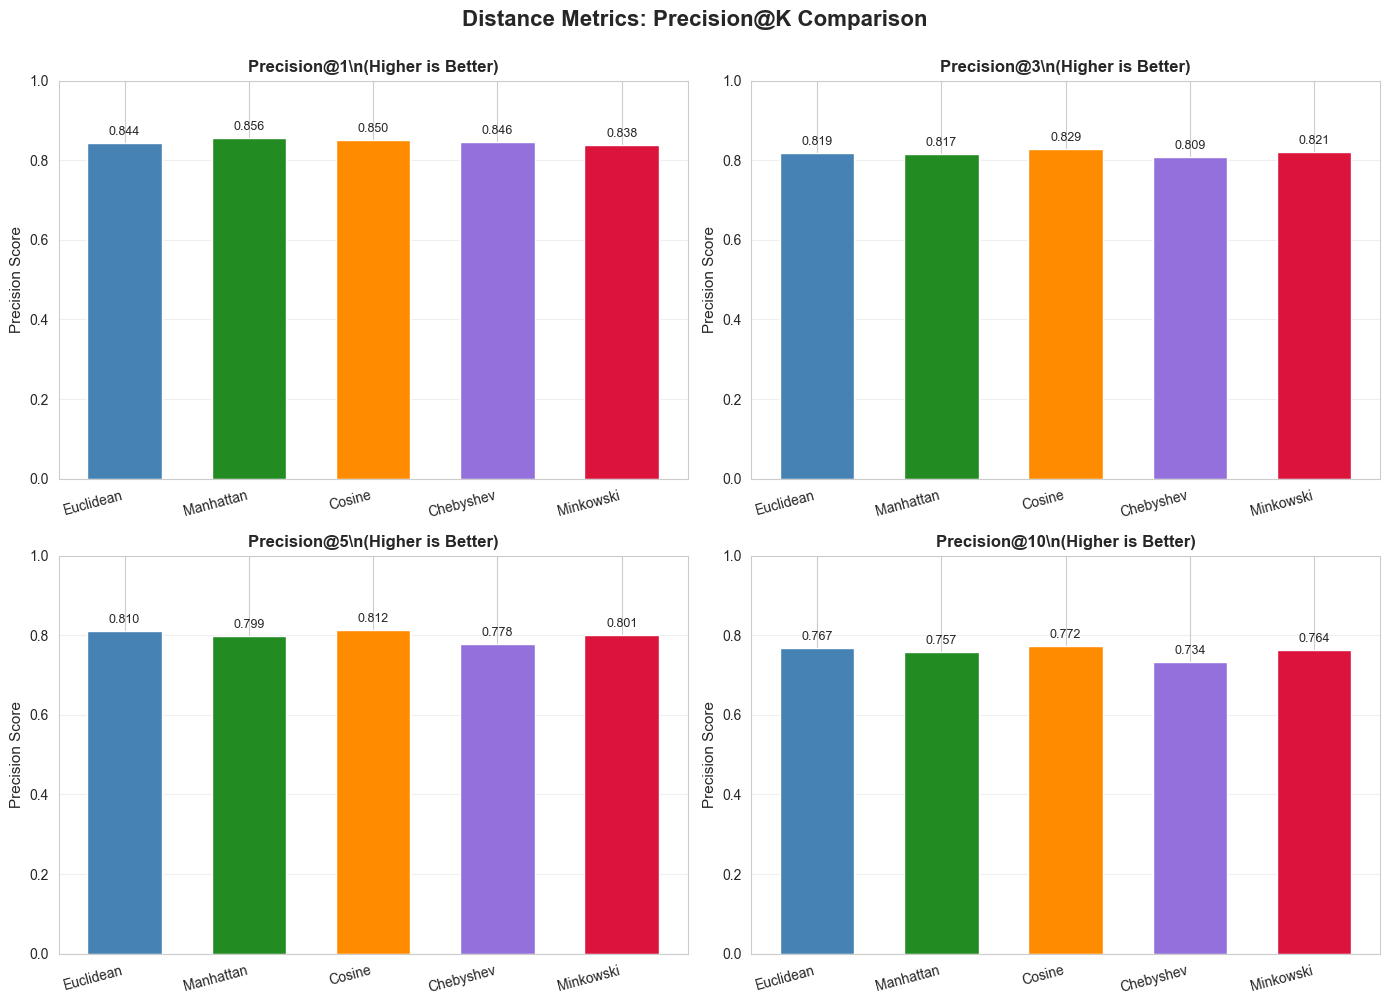

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['steelblue', 'forestgreen', 'darkorange', 'mediumpurple', 'crimson']

k_values = [1, 3, 5, 10]
x = np.arange(len(distance_metrics))
width = 0.2

for i, k in enumerate(k_values):
    ax = axes[i // 2, i % 2]
    precision_values = [np.mean(results[m][f'P@{k}']) for m in distance_metrics]
    
    ax.bar(x, precision_values, width=0.6, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels([m.capitalize() for m in distance_metrics], rotation=15, ha='right')
    ax.set_ylabel('Precision Score', fontsize=11)
    ax.set_title(f'Precision@{k}\\n(Higher is Better)', fontweight='bold', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    for j, v in enumerate(precision_values):
        ax.text(j, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.suptitle('Distance Metrics: Precision@K Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('precision_at_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Overall Quality Metrics Comparison

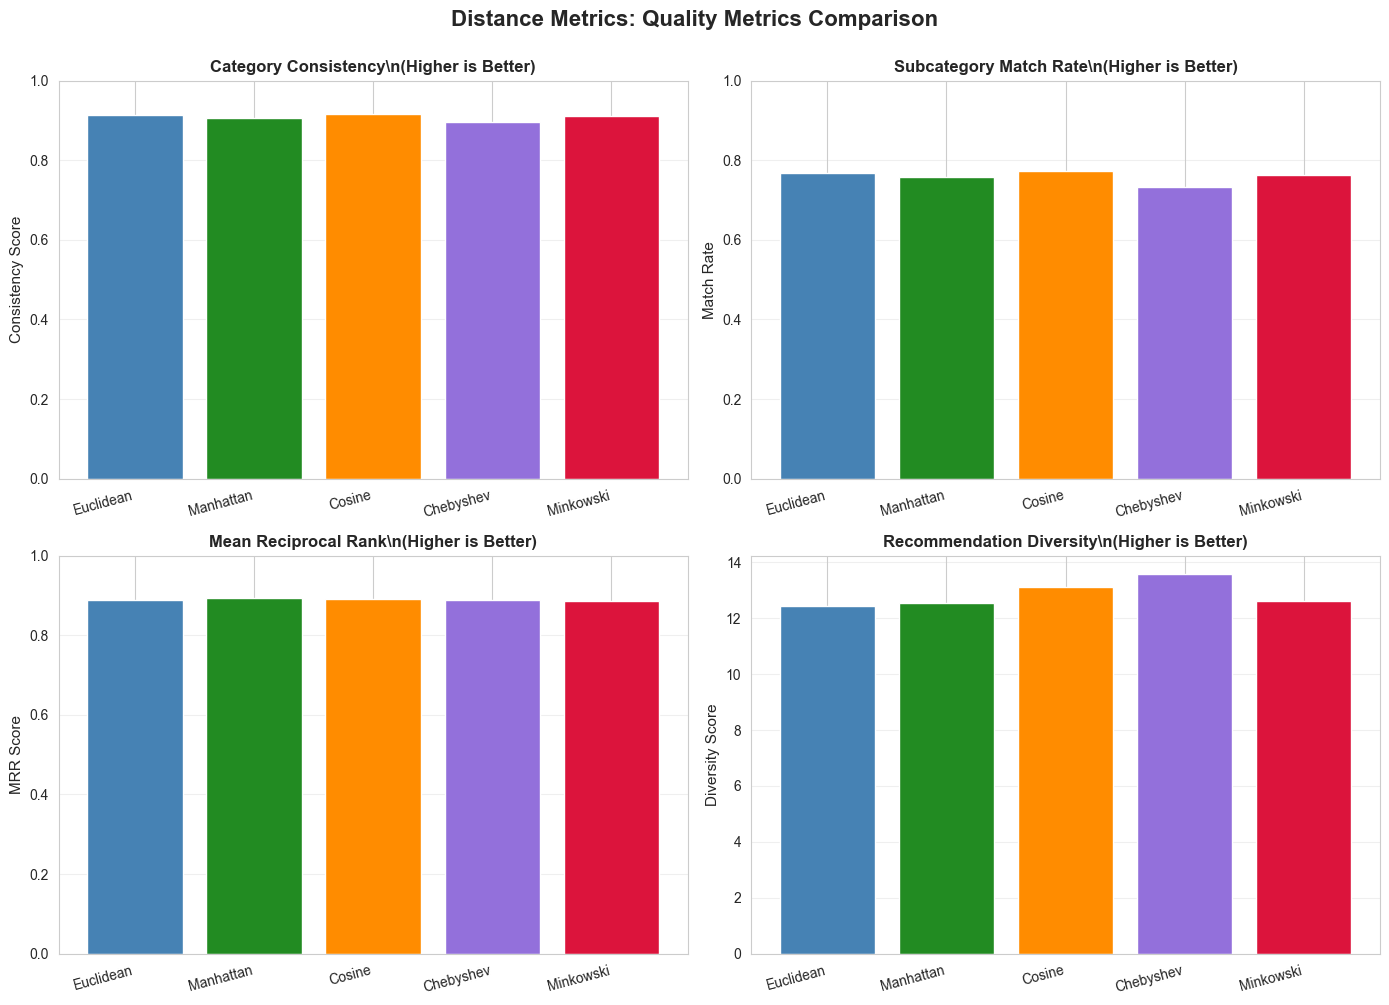

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

category_consistency = [np.mean(results[m]['category_consistency']) for m in distance_metrics]
axes[0, 0].bar(range(len(distance_metrics)), category_consistency, color=colors)
axes[0, 0].set_xticks(range(len(distance_metrics)))
axes[0, 0].set_xticklabels([m.capitalize() for m in distance_metrics], rotation=15, ha='right')
axes[0, 0].set_ylabel('Consistency Score', fontsize=11)
axes[0, 0].set_title('Category Consistency\\n(Higher is Better)', fontweight='bold', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1])

subcategory_match = [np.mean(results[m]['subcategory_match']) for m in distance_metrics]
axes[0, 1].bar(range(len(distance_metrics)), subcategory_match, color=colors)
axes[0, 1].set_xticks(range(len(distance_metrics)))
axes[0, 1].set_xticklabels([m.capitalize() for m in distance_metrics], rotation=15, ha='right')
axes[0, 1].set_ylabel('Match Rate', fontsize=11)
axes[0, 1].set_title('Subcategory Match Rate\\n(Higher is Better)', fontweight='bold', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0, 1])

mrr_values = [np.mean(results[m]['mrr']) for m in distance_metrics]
axes[1, 0].bar(range(len(distance_metrics)), mrr_values, color=colors)
axes[1, 0].set_xticks(range(len(distance_metrics)))
axes[1, 0].set_xticklabels([m.capitalize() for m in distance_metrics], rotation=15, ha='right')
axes[1, 0].set_ylabel('MRR Score', fontsize=11)
axes[1, 0].set_title('Mean Reciprocal Rank\\n(Higher is Better)', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0, 1])

diversity_values = [np.mean(results[m]['diversity']) for m in distance_metrics]
axes[1, 1].bar(range(len(distance_metrics)), diversity_values, color=colors)
axes[1, 1].set_xticks(range(len(distance_metrics)))
axes[1, 1].set_xticklabels([m.capitalize() for m in distance_metrics], rotation=15, ha='right')
axes[1, 1].set_ylabel('Diversity Score', fontsize=11)
axes[1, 1].set_title('Recommendation Diversity\\n(Higher is Better)', fontweight='bold', fontsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Distance Metrics: Quality Metrics Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('quality_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Computation Time Comparison

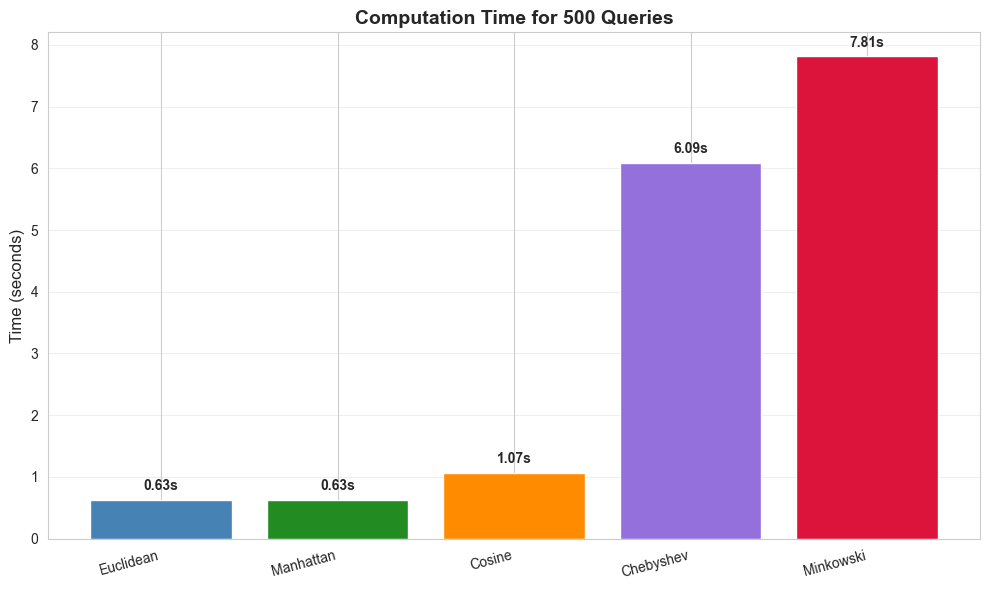

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

comp_times = [results[m]['computation_time'] for m in distance_metrics]

ax.bar(range(len(distance_metrics)), comp_times, color=colors)
ax.set_xticks(range(len(distance_metrics)))
ax.set_xticklabels([m.capitalize() for m in distance_metrics], rotation=15, ha='right')
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Computation Time for 500 Queries', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(comp_times):
    ax.text(i, v + max(comp_times)*0.02, f'{v:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('computation_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Recommendation Examples

### Visualize Sample Recommendations for Each Distance Metric

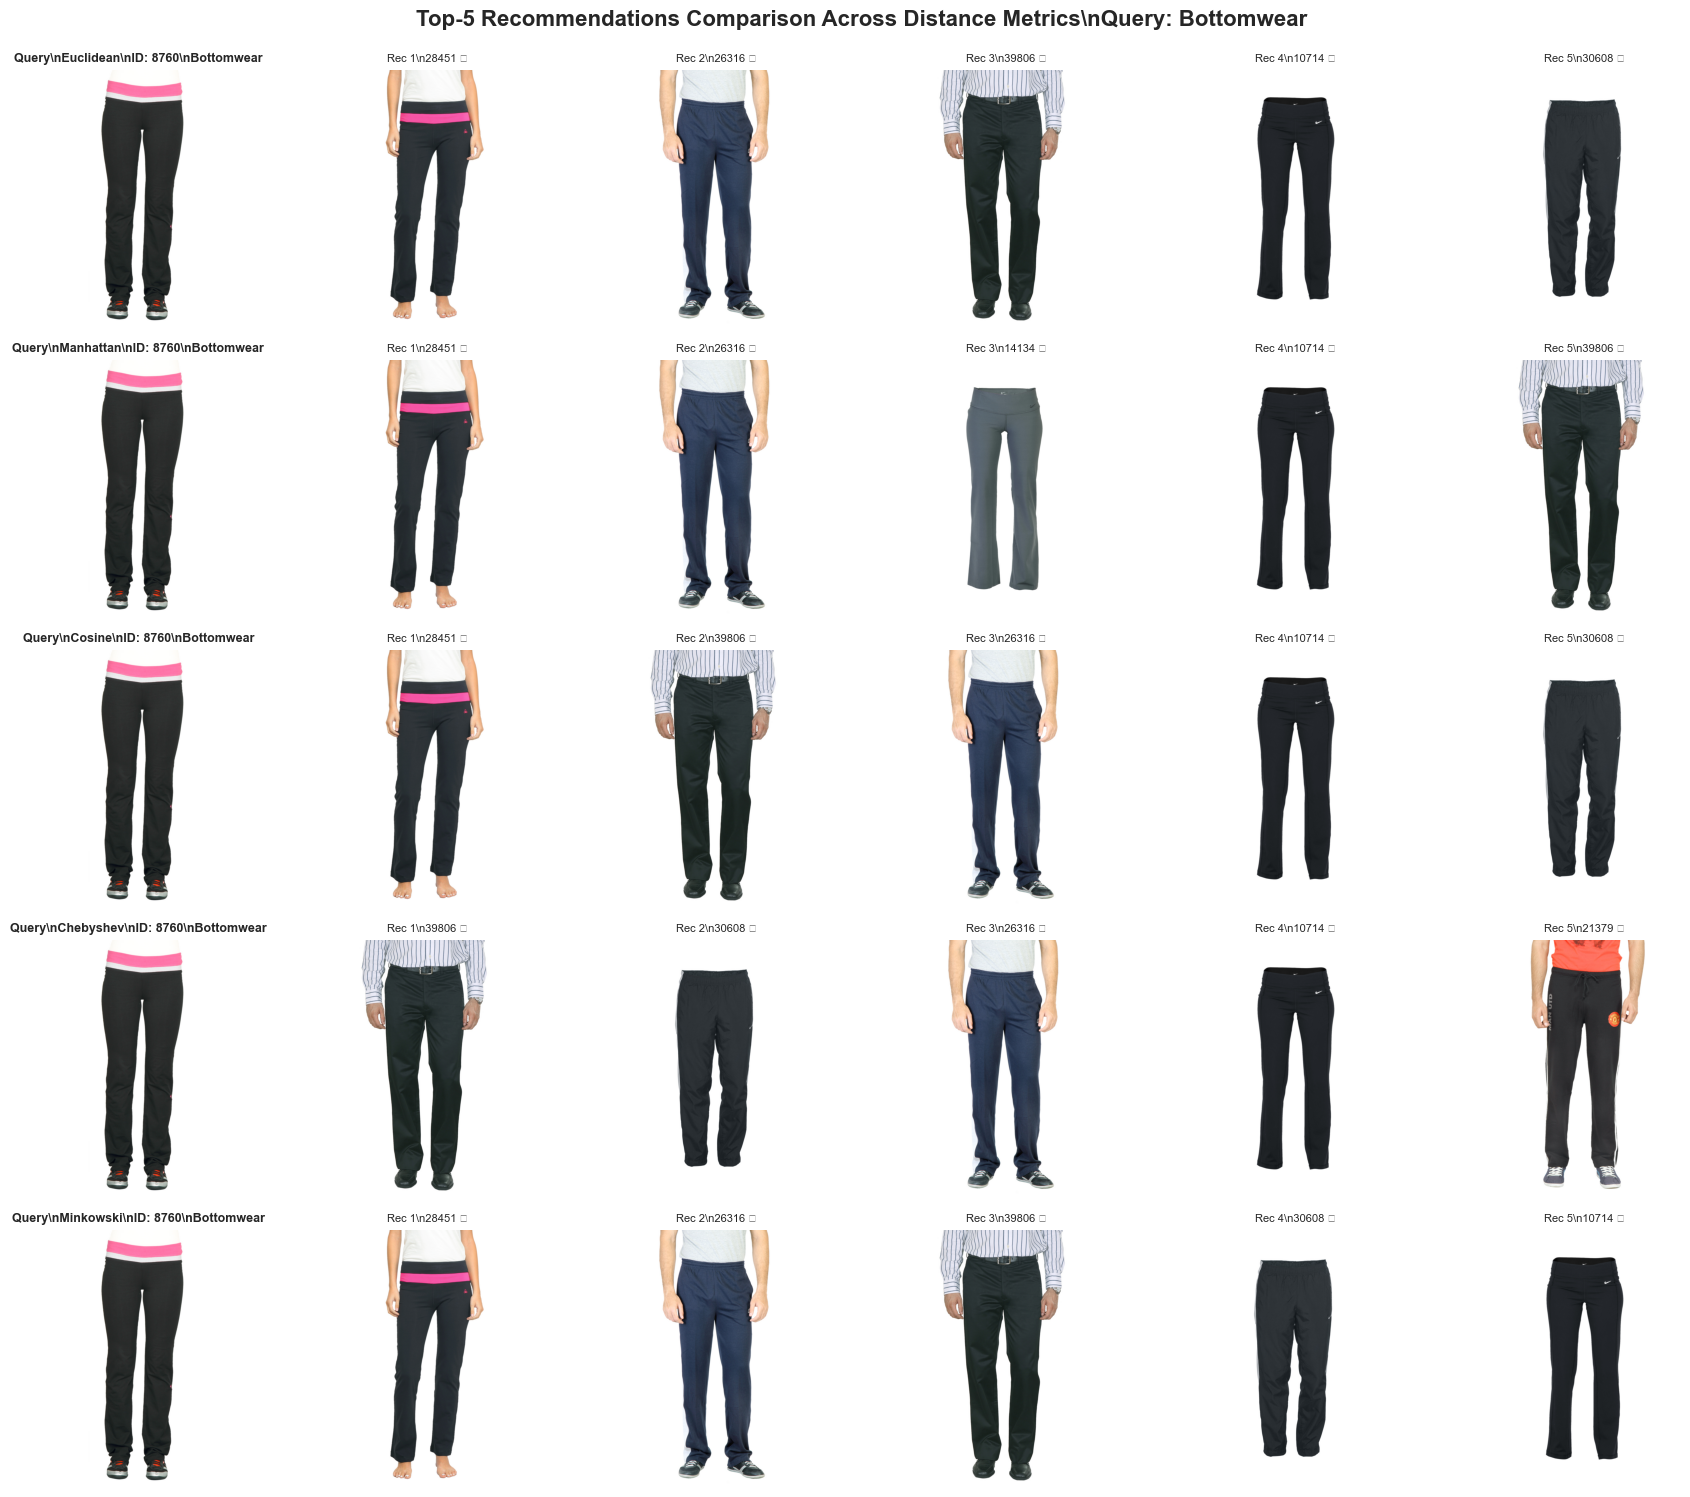

In [28]:
query_idx = np.random.choice(test_indices)
query_img_id = df_valid.iloc[query_idx]['id']
query_subcat = df_valid.iloc[query_idx]['subCategory']

fig, axes = plt.subplots(len(distance_metrics), 6, figsize=(18, 3 * len(distance_metrics)))

for row_idx, metric in enumerate(distance_metrics):
    query_path = os.path.join(image_dir, f"{query_img_id}.jpg")
    
    axes[row_idx, 0].imshow(Image.open(query_path))
    axes[row_idx, 0].set_title(f"Query\\n{metric.capitalize()}\\nID: {query_img_id}\\n{query_subcat}", 
                                fontsize=9, fontweight="bold")
    axes[row_idx, 0].axis("off")
    
    recommendations = get_top_k_recommendations(query_idx, features, cluster_labels, metric, k=5)
    
    for col_idx, rec_idx in enumerate(recommendations, start=1):
        rec_img_id = df_valid.iloc[rec_idx]['id']
        rec_subcat = df_valid.iloc[rec_idx]['subCategory']
        rec_path = os.path.join(image_dir, f"{rec_img_id}.jpg")
        
        axes[row_idx, col_idx].imshow(Image.open(rec_path))
        match = "✓" if rec_subcat == query_subcat else "✗"
        axes[row_idx, col_idx].set_title(f"Rec {col_idx}\\n{rec_img_id} {match}", fontsize=8)
        axes[row_idx, col_idx].axis("off")

plt.suptitle(f"Top-5 Recommendations Comparison Across Distance Metrics\\nQuery: {query_subcat}", 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('recommendations_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical Analysis

### Metric Distribution Visualization

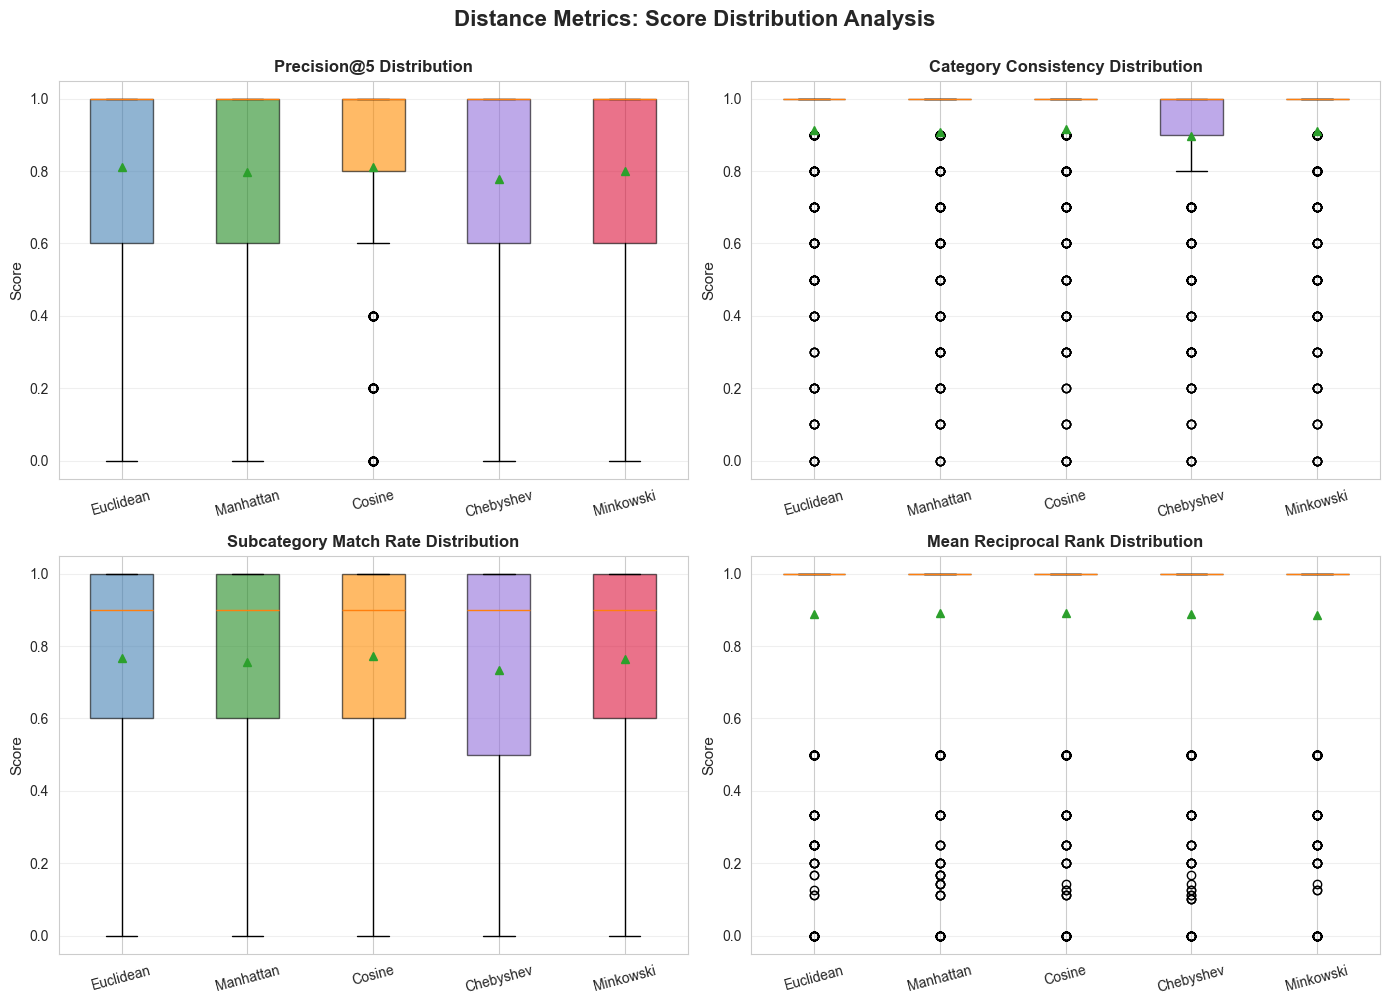

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['P@5', 'category_consistency', 'subcategory_match', 'mrr']
titles = ['Precision@5', 'Category Consistency', 'Subcategory Match Rate', 'Mean Reciprocal Rank']

for idx, (metric_name, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    data_for_plot = []
    labels_for_plot = []
    for dist_metric in distance_metrics:
        data_for_plot.append(results[dist_metric][metric_name])
        labels_for_plot.append(dist_metric.capitalize())
    
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True, showmeans=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{title} Distribution', fontweight='bold', fontsize=12)
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distance Metrics: Score Distribution Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('score_distribution_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

### Best Performing Metric Analysis

In [30]:
ranking_metrics = ['P@1', 'P@3', 'P@5', 'P@10', 'category_consistency', 'subcategory_match', 'mrr']
rankings = {metric: [] for metric in distance_metrics}

for eval_metric in ranking_metrics:
    scores = [(m, np.mean(results[m][eval_metric])) for m in distance_metrics]
    scores.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (metric, score) in enumerate(scores, start=1):
        rankings[metric].append(rank)

avg_rankings = {m: np.mean(rankings[m]) for m in distance_metrics}
best_metric = min(avg_rankings, key=avg_rankings.get)

print("Average Rankings:\n")
for metric in sorted(avg_rankings, key=avg_rankings.get):
    print(f"{metric.capitalize()}: {avg_rankings[metric]:.2f}")

Average Rankings:

Cosine: 1.29
Euclidean: 2.71
Manhattan: 3.14
Minkowski: 3.43
Chebyshev: 4.43
